In [1]:
import pandas as pd

file_path = 'bike-sharing-dataset/hour.csv'
rides = pd.read_csv(file_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# 数据预处理

## 处理类型变量

In [11]:
#所有类型编码变量的名称
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix = each, drop_first = False)
    rides = pd.concat([rides, dummies], axis = 1)
fields_to_drop = ['instant','dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis = 1)
data.head

<bound method NDFrame.head of        yr  holiday  temp   hum  windspeed  casual  registered  cnt  season_1  \
0       0        0  0.24  0.81     0.0000       3          13   16      True   
1       0        0  0.22  0.80     0.0000       8          32   40      True   
2       0        0  0.22  0.80     0.0000       5          27   32      True   
3       0        0  0.24  0.75     0.0000       3          10   13      True   
4       0        0  0.24  0.75     0.0000       0           1    1      True   
...    ..      ...   ...   ...        ...     ...         ...  ...       ...   
17374   1        0  0.26  0.60     0.1642      11         108  119      True   
17375   1        0  0.26  0.60     0.1642       8          81   89      True   
17376   1        0  0.26  0.60     0.1642       7          83   90      True   
17377   1        0  0.26  0.56     0.1343      13          48   61      True   
17378   1        0  0.26  0.65     0.1343      12          37   49      True   

       se

## 处理数值类型变量

In [76]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std 
scaled_features

{'cnt': [2.4531080122910415e-18, 1.0000000000000007],
 'temp': [8.504107775942278e-17, 0.9999999999999906],
 'hum': [-3.107270148901986e-17, 0.9999999999999947],
 'windspeed': [-3.2708106830547222e-18, 1.0000000000000115]}

## 数据集划分

In [61]:
import numpy as np

test_data = data[-21*24: ]
train_data = data[: -21*24]
target_fields = ['cnt', 'casual', 'registered']

features, targets = train_data.drop(target_fields, axis = 1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]

features = pd.concat([features.iloc[:, :5] ,features.iloc[:, 5:].astype(int)], axis = 1)
X = features.values
Y = targets['cnt'].values
Y = Y.astype(float)
Y = np.reshape(Y, [len(Y), 1])
losses = []
X


array([[ 0.        ,  0.        , -1.33460919, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        , -1.43847501, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        , -1.43847501, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.        ,  0.        ,  0.11951233, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        , -0.19208513, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        , -0.19208513, ...,  0.        ,
         0.        ,  0.        ]])

# 构建神经网络

In [80]:
import torch
import torch.optim as optim

input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128

#调用现成函数进行构建
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)

cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01)
neu

Sequential(
  (0): Linear(in_features=56, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

## 数据批处理

0 0.9205901
100 0.27502638
200 0.25302193
300 0.20859173
400 0.14221229
500 0.102603406
600 0.084284276
700 0.07583857
800 0.07061417
900 0.06689821


Text(0, 0.5, 'MSE')

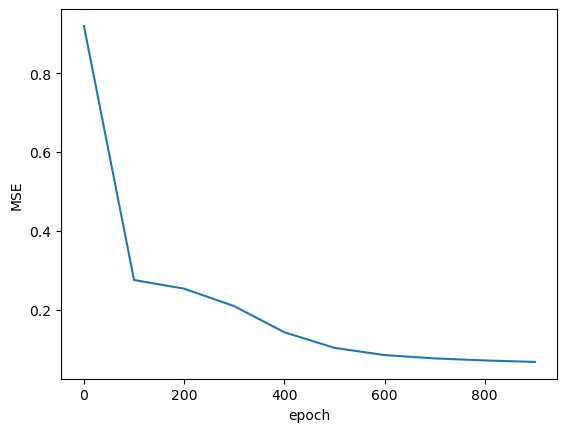

In [63]:
import matplotlib.pyplot as plt

losses = []
batch_size = 128
for i in range(1000):
    batch_loss = []
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.FloatTensor(X[start: end])
        yy = torch.FloatTensor(Y[start: end])
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))
plt.plot(np.arange(len(losses))*100, losses)
plt.xlabel('epoch')
plt.ylabel('MSE')


## 测试神经网络

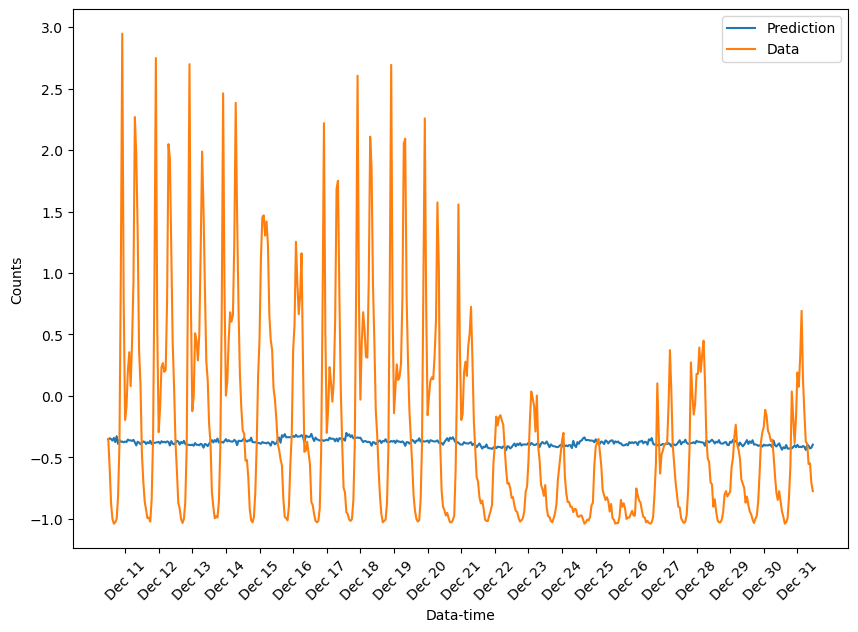

In [93]:
targets = test_targets['cnt']
targets = targets.values.reshape([len(targets), 1])
targets = targets.astype(float)

test_features = pd.concat([test_features.iloc[:, :5], test_features.iloc[:, 5:].astype(int)], axis = 1)
x = torch.FloatTensor(test_features.values)
y = torch.FloatTensor(targets)

#用神经网络进行预测：
predict = neu(x)
# predict.data.numpy()  #有梯度信息的tensor不能直接转换成numpy(),要使用detach().numpy()
# predict = predict.detach().numpy()
predict = predict.data.numpy()
fig, ax = plt.subplots(figsize = (10, 7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label = 'Prediction')
ax.plot(targets * std + mean, label = 'Data')
ax.legend()
ax.set_xlabel("Data-time")
ax.set_ylabel("Counts")
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])#将 Pandas DataFrame 中的日期列 'dteday' 转换为 Pandas 的日期时间对象
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation = 45)